## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
!pip install -Uqq fastai duckduckgo_search

In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -Uqq fastai duckduckgo_search

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

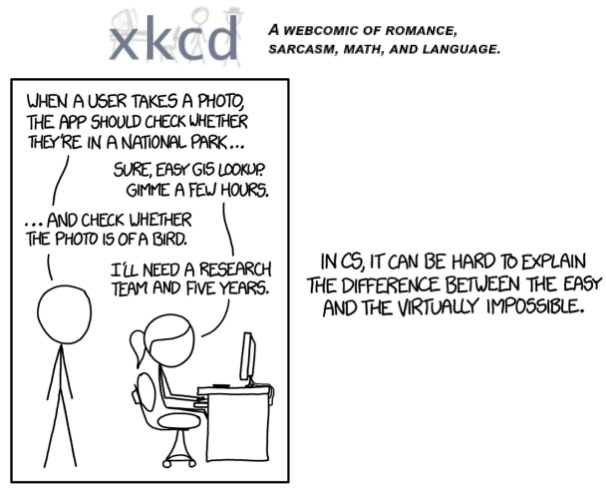

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [35]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('collard green photos', max_images=1)
urls[0]

Searching for 'collard green photos'


'https://www.thespruce.com/thmb/N57BLtW7mdS4Xpz2abJbV1alXDA=/3456x2304/filters:fill(auto,1)/collard-5885420f5f9b58bdb3936a36.jpg'

...and then download a URL and take a look at it:

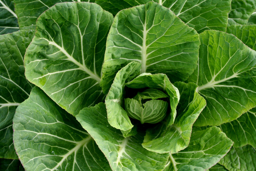

In [36]:
from fastdownload import download_url
dest = 'collard_green.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'baby spinach photos'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


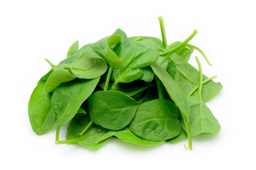

In [8]:
download_url(search_images('baby spinach photos', max_images=1)[0], 'baby_spinach.jpg', show_progress=False)
Image.open('baby_spinach.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [12]:
searches = 'spinach','kale','collard greens'
path = Path('babyS_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'spinach photo'
Searching for 'spinach sun photo'
Searching for 'spinach shade photo'
Searching for 'kale photo'
Searching for 'kale sun photo'
Searching for 'kale shade photo'
Searching for 'collard greens photo'
Searching for 'collard greens sun photo'
Searching for 'collard greens shade photo'


### Delete filed from kaggle working directory

In [23]:
import os
import glob
for file in glob.glob("/kaggle/working/babyS_or_not/normal spinach/*"):
    os.remove(file)
os.rmdir("/kaggle/working/babyS_or_not/normal spinach")

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

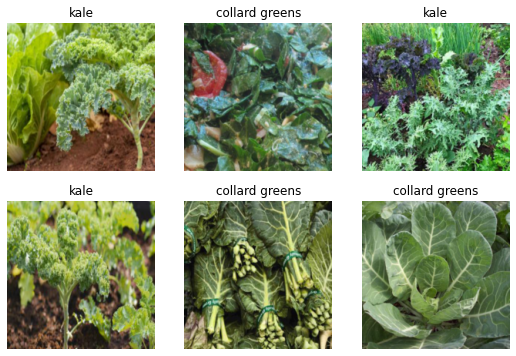

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.636015,1.594921,0.458333,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.764089,1.111246,0.354167,00:01
1,0.561089,0.980458,0.270833,00:01
2,0.441767,0.878412,0.229167,00:01
3,0.342604,0.877196,0.250000,00:01
4,0.269094,0.962451,0.250000,00:01
5,0.214360,0.962273,0.250000,00:01
6,0.173552,0.955985,0.229167,00:01
7,0.143973,0.927839,0.250000,00:01
8,0.120809,0.932124,0.250000,00:01
9,0.104569,0.936361,0.250000,00:01


> **error rate is not decreasing. is model training saturated?**

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

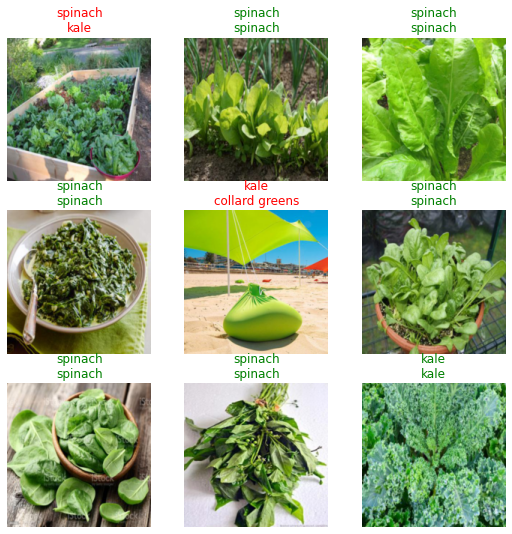

In [45]:
learn.show_results()

In [49]:
is_bird,_,probs = learn.predict(PILImage.create('kale.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a {is_bird}: {probs[0]:.4f}")

This is a: kale.
Probability it's a kale: 0.0002


> **probability of falling in each category even though right is very small?**

In [1]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.451534,0.391834,0.823960,02:19


epoch,train_loss,valid_loss,accuracy,time
0,0.313383,0.365573,0.829520,04:16
1,0.247750,0.211392,0.915760,04:16
2,0.193666,0.189785,0.928120,04:16
3,0.139852,0.198656,0.927400,04:17


In [1]:


learn.predict("I really liked that movie!")
     


NameError: name 'learn' is not defined

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

## notes from book chapter
1. Computers, as any programmer will tell you, are giant morons, not giant brains
2. Universal approximation theorem - neural network function can solve any problem with any level of accuracy in theory
3. weigth updates - Stochastic gradient descent (SGD)
4. labelling approaches
5. overfitting prevention only when required 
6. Gramian Angular Difference Field  - time series to image data

## coding tips
1. create path object instead of string 

## fastai
1. item_tfms and batch_tfms
2. When you use the fine_tune method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:
- Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
- Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).
3. doc(learn.predict) - for documentation
4. fit_one_cycle, the most commonly used method for training fastai models from scratch (i.e. without transfer learning)
5.  Sometimes it's best to experiment with fine_tune versus fit_one_cycle to see which works best for your dataset.


## things not done
1. , it is not yet well understood how to use transfer learning for tasks such as time series analysis.



## research questions self
 1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?
  2. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice.

